## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from selenium import webdriver
from bs4 import BeautifulSoup
import time
import os
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout

%matplotlib inline

In [2]:
plt.figure(figsize=(12, 6))
plt.subplots_adjust(top=2.5, bottom=1.7)
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('fivethirtyeight')

<Figure size 864x432 with 0 Axes>

# Method 1 -
First User needs to input 4 different stocks (Stock Code, Stock Name).

Second, Selenium and BeautifulSoup will crawl and fetch all the data from "Yahoo Finance".

Finally will create 5 Dataframes and CSV, 1 for Each stock and one Big DF including all data.

# Prompting User to Input the Stocks for which forecasting and Analysis is to be made

In [ ]:
# Example of Stock's code: AAPL, NFLX, MA, TSLA
# Example of Stock's name: Apple, Netflix, Mastercard, Tesla

stock_code = []
stock_name = []

print("Please enter the Stock's Code and then The Stock's Name, Do it 4 times for different stocks.")
print("Here is an example for Stock Code: Googl, AAPL ")
print("And another example for Stock name: Google, Apple ")

for i in range(0,4):
    stock_code.append(input(f"The {i+1} Stock Code: "))
    stock_name.append(input(f"The {i+1} Stock Name: "))


# Crawling and Fetching the historical data of each stock, Then Creating DataFrames.

In [ ]:
company_df = []
for code, name in zip(stock_code, stock_name):
    try:
        # BaseURL of Yahoo Finance website
        URL = "https://finance.yahoo.com/"

        # Start the Driver
        #driver = webdriver.Chrome(executable_path = Stock Prediction folder - chromedriver.exe")
        driver = webdriver.Chrome(os.getcwd() + "./chromedriver.exe")
        
        # Hit the url of Yahoo Finance
        driver.get(URL)
        time.sleep(2)

        # Code = Stock name code
        # Enter name of company in searchbox
        driver.find_element_by_xpath("//input[@placeholder = 'Search for news, symbols or companies']").send_keys(code)
        time.sleep(2)
        print(f"Fetching historical stock data from Yahoo Finance for - {name}")

        # Click on Search icon
        driver.find_element_by_xpath("//button[@id= 'header-desktop-search-button']").click()
        time.sleep(2)

        # Clicks on "Historical Data"  
        driver.find_element_by_xpath("//span[text() = 'Historical Data']").click()
        time.sleep(2)

        # Open data range table
        driver.find_element_by_xpath("//*[@id='Col1-1-HistoricalDataTable-Proxy']/section/div[1]/div[1]/div[1]/div/div").click()
        time.sleep(2)
        
        # Setting limit to max
        driver.find_element_by_xpath('//*[@id="dropdown-menu"]/div/ul[2]/li[4]/button/span').click() 
        time.sleep(2)

        # Applying changes 
        driver.find_element_by_xpath('//*[@id="Col1-1-HistoricalDataTable-Proxy"]/section/div[1]/div[1]/button/span').click()
        time.sleep(2)

        # Scrolling down to load the table.
        print("Collecting all data...")
        for i in range(0,25):
            driver.execute_script("window.scrollBy(0,10000)")
            time.sleep(4)

        # Web page fetched from driver is parsed using Beautiful Soup.
        HTMLPage = BeautifulSoup(driver.page_source, 'html.parser')

        # Table is searched using class and stored in another variable.
        Table = HTMLPage.find('table', class_='W(100%) M(0)')

        # List of all the rows is store in a variable 'Rows'.
        Rows = Table.find_all('tr', class_='BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)')

        # Empty list is created to store the data
        extracted_data = []
        # Loop to go through each row of table
        for i in range(0, len(Rows)):
            try:
                # Empty dictionary to store data present in each row
                RowDict = {}
                # Extracting all columns of a row and storing in a variable
                Values = Rows[i].find_all('td')

                # Values (Open, High, Close etc.) are extracted and stored in dictionary
                if len(Values) == 7:
                    # Using Replace to fix numericals values
                    RowDict["Date"] = Values[0].find('span').text.replace(',', '')
                    RowDict["Open"] = Values[1].find('span').text.replace(',', '')
                    RowDict["High"] = Values[2].find('span').text.replace(',', '')
                    RowDict["Low"] = Values[3].find('span').text.replace(',', '')
                    RowDict["Close"] = Values[4].find('span').text.replace(',', '')
                    RowDict["Adj Close"] = Values[5].find('span').text.replace(',', '')
                    RowDict["Volume"] = Values[6].find('span').text.replace(',', '')
                    RowDict["Company"] = name 

                    # Dictionary is appended in list
                    extracted_data.append(RowDict)
            except:
                # To check the exception caused for which company
                print("Row Number: " + str(i))
            finally:
                # To move to the next row
                i = i + 1
                
        #Converted list of dictionaries to a Dataframe.
        print("Converted list of dictionaries to a Dataframe") 
        globals()[code] = pd.DataFrame(extracted_data)
        # globals()[code].to_csv(f"{name}.csv") - Creating CSV for each stock
        company_df.append(globals()[code])
        print(f"Finished Collecting information for {name}")
        print("-----")
    except:
        break
        
if len(company_df) == 4:
    stock_data = pd.concat(company_df, axis = 0)
    # stock_data.to_csv("Stocks_Data.csv") - Creating one CSV for all data.
else:
    print("Something didn't work, You have to try fetching again...")

## Method 2 (optional) - Reading the data from CSV we already created using Method 1.

In [3]:
# Reading Data Frames from folder..
company_df = []
stock_code = ['AAPL', 'NFLX', 'MA', 'TSLA']
stock_name = ['Apple', 'Netflix', 'Mastercard', 'Tesla']

for code, name in zip(stock_code, stock_name):
    globals()[code] = pd.read_csv(f"{name}.csv",index_col = 0)
    company_df.append(globals()[code])
    
stock_data = pd.read_csv("Stocks_Data.csv",index_col = 0)

## Now let's Explore and take care of our data

In [4]:
stock_data.info() # Our data is full no missing value - Great!

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9423 entries, 0 to 2298
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9423 non-null   object 
 1   Open       9423 non-null   float64
 2   High       9423 non-null   float64
 3   Low        9423 non-null   float64
 4   Close      9423 non-null   float64
 5   Adj Close  9423 non-null   float64
 6   Volume     9423 non-null   int64  
 7   Company    9423 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 662.6+ KB


In [ ]:
# Shifting our Numeric data from object into Float\Int
# After using Method 1 all dtype will be object so we change the Numeric one into Float and Int
# Method 2 doesn't need that

Numeric_cat = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

for numeric in Numeric_cat:
    stock_data[numeric] = pd.to_numeric(stock_data[numeric],errors = 'coerce')

for comp in company_df:
    for numeric in Numeric_cat:
        comp[numeric] = pd.to_numeric(comp[numeric],errors = 'coerce')

stock_data.info() 

In [5]:
stock_data.duplicated().sum() # no duplicated rows

0

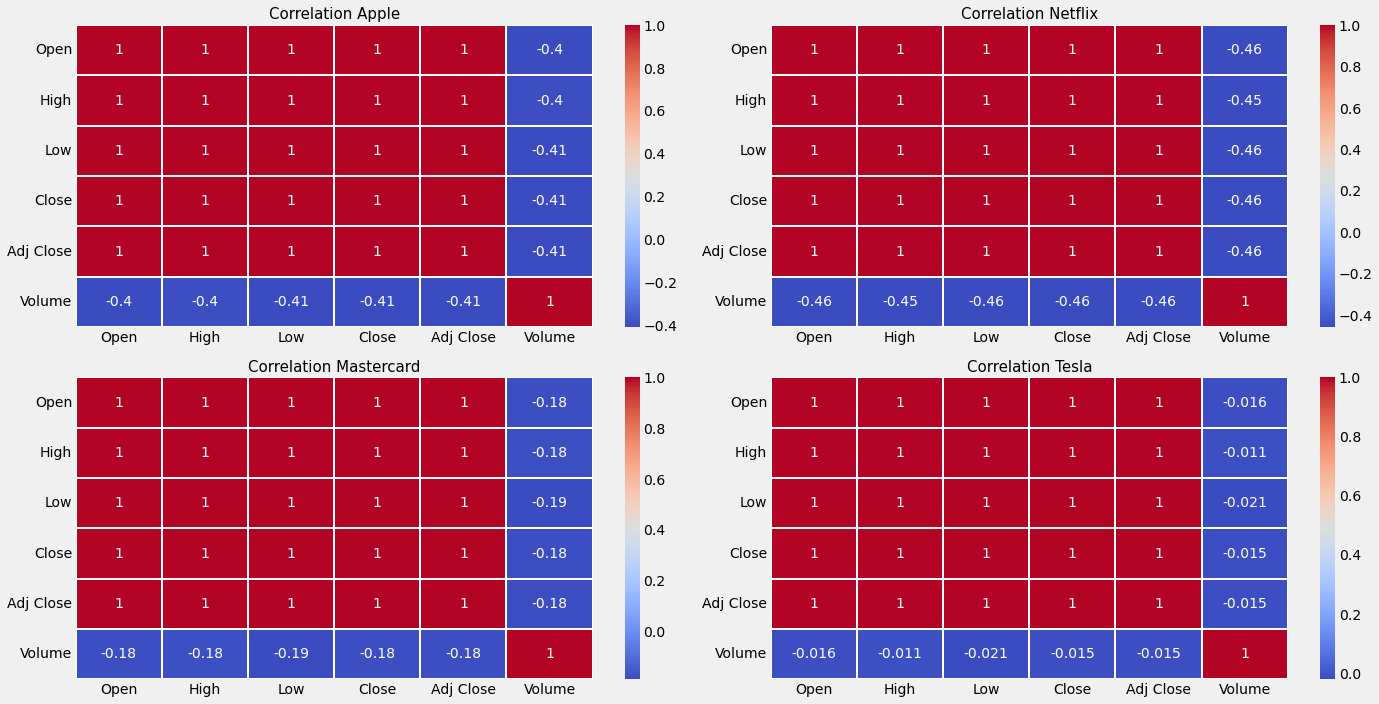

In [6]:
#Correlation for each stock separately, comaparing each column with each other.
Numeric_cat = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
for i in range(0,4):
    comp = (stock_data.loc[stock_data['Company'] == stock_name[i]])[Numeric_cat]
    plt.subplot(2, 2, i+1)
    plt.title(f"Correlation {stock_name[i]}", fontsize = 15)
    sns.heatmap(comp.corr() , annot = True, cmap = 'coolwarm', linewidth = 0.25)

plt.tight_layout()

In [7]:
# outliers with IQR
for i in range(4):
    print(f"Looking for outliers in {stock_name[i]}[Close] stock: ")
    comp = (stock_data.loc[stock_data['Company'] == stock_name[i]])["Close"]
    Q1 = np.percentile(comp , 25)
    Q3 = np.percentile(comp , 75)
    IQR = Q3 -Q1
    Fare_outlier_rows = comp[(comp < Q1-1.5*IQR) | (comp > Q3 + 1.5*IQR)].index
    print(len(Fare_outlier_rows))
    print("-----")

Looking for outliers in Apple[Close] stock: 
365
-----
Looking for outliers in Netflix[Close] stock: 
0
-----
Looking for outliers in Mastercard[Close] stock: 
0
-----
Looking for outliers in Tesla[Close] stock: 
473
-----


 we found outlier but we won't remove them, because it will hurt our prediction ignoring "fact data"

# EDA

In [8]:
# Describing each of Company Close data.

for comp,i in zip(company_df,stock_name):
    print(f"Describing {i} Close Data")
    print(comp['Close'].describe())
    print("-----")


Describing Apple Close Data
count    2262.000000
mean       52.744187
std        40.125051
min        13.950000
25%        26.272500
50%        38.190000
75%        58.447500
max       182.010000
Name: Close, dtype: float64
-----
Describing Netflix Close Data
count    2599.000000
mean      207.151016
std       184.534255
min         7.690000
25%        51.870000
50%       124.050000
75%       351.345000
max       691.690000
Name: Close, dtype: float64
-----
Describing Mastercard Close Data
count    2263.000000
mean      175.691233
std       105.151247
min        50.970000
25%        87.880000
50%       127.430000
75%       272.935000
max       395.650000
Name: Close, dtype: float64
-----
Describing Tesla Close Data
count    2299.000000
mean      157.427995
std       250.472827
min         6.430000
25%        42.060000
50%        52.000000
75%        71.470000
max      1229.910000
Name: Close, dtype: float64
-----


Dividing Apple[Close] into 30 bins: 
(25.154, 30.756]      0.170645
(13.782, 19.552]      0.127763
(19.552, 25.154]      0.101238
(41.96, 47.562]       0.094164
(30.756, 36.358]      0.082670
(36.358, 41.96]       0.075597
(47.562, 53.164]      0.061008
(53.164, 58.766]      0.037135
(120.388, 125.99]     0.024757
(125.99, 131.592]     0.021220
(75.572, 81.174]      0.020778
(114.786, 120.388]    0.020778
(131.592, 137.194]    0.020336
(64.368, 69.97]       0.020336
(142.796, 148.398]    0.019894
(148.398, 154.0]      0.017241
(69.97, 75.572]       0.014147
(58.766, 64.368]      0.013263
(109.184, 114.786]    0.009726
(92.378, 97.98]       0.007958
(170.806, 176.408]    0.006631
(137.194, 142.796]    0.006631
(86.776, 92.378]      0.006189
(81.174, 86.776]      0.004863
(176.408, 182.01]     0.003979
(159.602, 165.204]    0.003537
(103.582, 109.184]    0.003095
(154.0, 159.602]      0.002653
(165.204, 170.806]    0.001326
(97.98, 103.582]      0.000442
Name: Close, dtype: float64
----


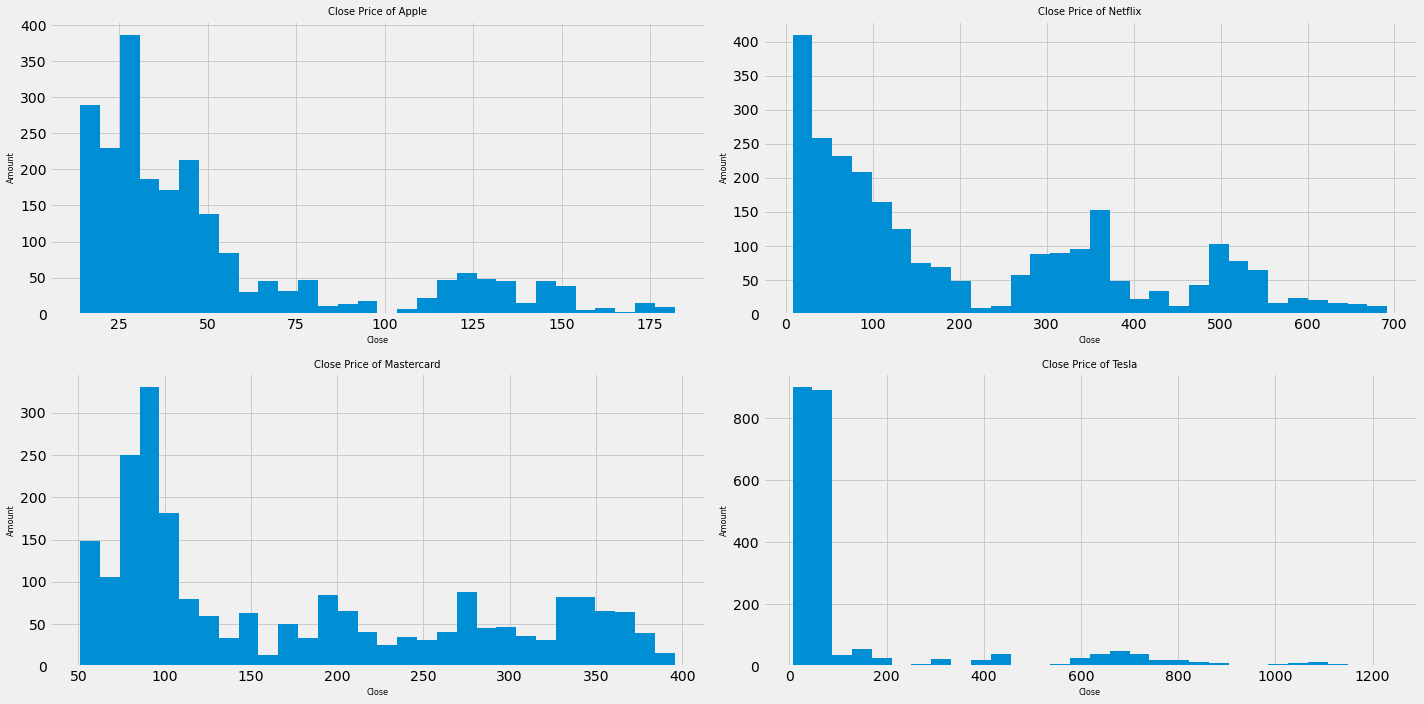

In [9]:
#bins and histograms to "Close" Column for each stock

# Dividing Close column into n bins 
for i in range(4):
    print(f"Dividing {stock_name[i]}[Close] into 30 bins: ")
    print(pd.cut((stock_data.loc[stock_data['Company'] == stock_name[i]])["Close"],bins = 30).value_counts(normalize = True))
    print("----") 
    
    plt.subplot(2, 2, i+1)
    plt.hist((stock_data.loc[stock_data['Company'] == stock_name[i]])["Close"], bins = 30)
    plt.ylabel('Amount',fontsize = 8)
    plt.xlabel('Close',fontsize = 8)
    plt.title(f"Close Price of {stock_name[i]}", fontsize = 10)
    
plt.tight_layout()

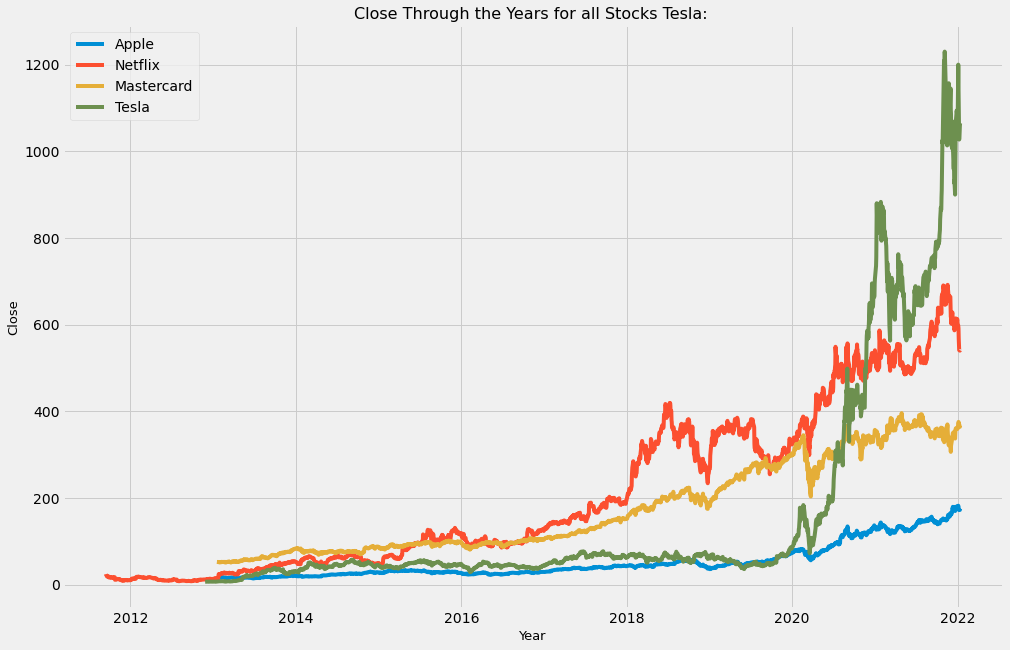

In [10]:
# All Stocks "Close" through the years...
plt.figure(figsize = (15,10))
b = ['Date','Close']
arr = []
for i in range(4):
    comp = (stock_data.loc[stock_data['Company'] == stock_name[i]])[b]
    arr.append(comp)
    
for i in range(4):
    arr[i]['Date'] = pd.to_datetime(arr[i]['Date'])
    plt.plot(arr[i]['Date'], arr[i]['Close'], label=stock_name[i])
    plt.legend(loc='best')
    plt.ylabel('Close',fontsize = 13)
    plt.xlabel('Year',fontsize = 13)
    plt.title(f"Close Through the Years for all Stocks {stock_name[i]}: ", fontsize = 16)
plt.show()

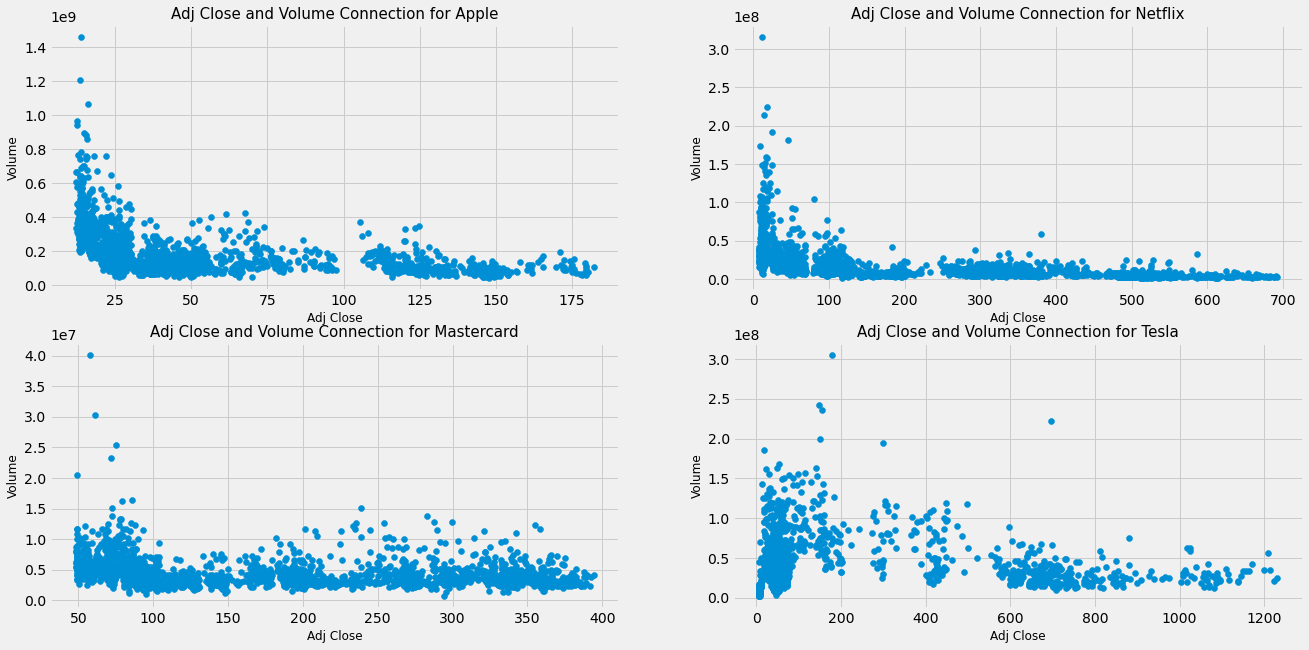

In [11]:
# Checking the kind of connection between two columnns (Volume and Adj Close).

for i in range(4):
    comp = stock_data[stock_data["Company"] == stock_name[i]]
    plt.subplot(2, 2, i+1)
    plt.scatter(comp["Adj Close"], comp["Volume"])
    plt.ylabel('Volume',fontsize = 12)
    plt.xlabel("Adj Close",fontsize = 12)
    plt.title(f"Adj Close and Volume Connection for {stock_name[i]}", fontsize = 15)


Here We can see there is not any connection between the two of them..

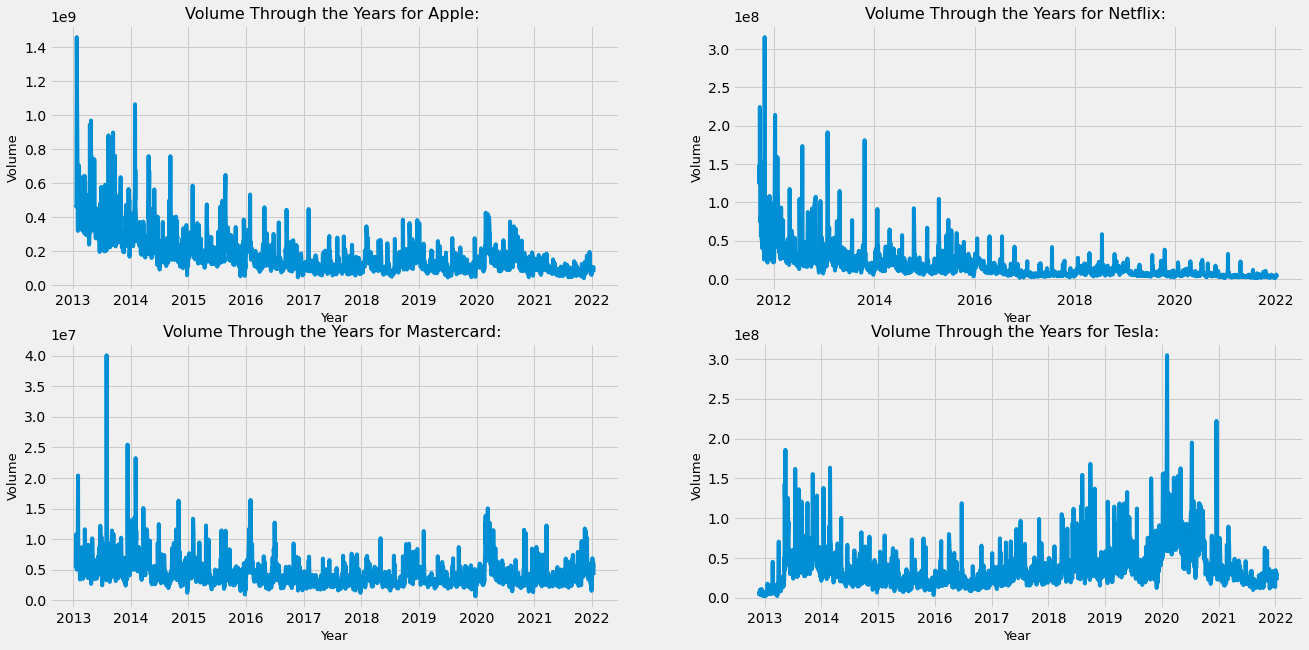

In [12]:
## Total volume of stock bieng traded each day

for i in range(4):
    comp = stock_data[stock_data["Company"] == stock_name[i]].copy()
    comp['Date'] = pd.to_datetime(comp['Date'])
    plt.subplot(2, 2, i+1)
    plt.plot(comp['Date'], comp['Volume'], label=stock_name[i])
    plt.ylabel('Volume',fontsize = 13)
    plt.xlabel('Year',fontsize = 13)
    plt.title(f"Volume Through the Years for {stock_name[i]}: ", fontsize = 16)

We can see here that during the year all stock volume went down except Tesla that during the Covid - 19 traded more and the stock volume grew bigger. 

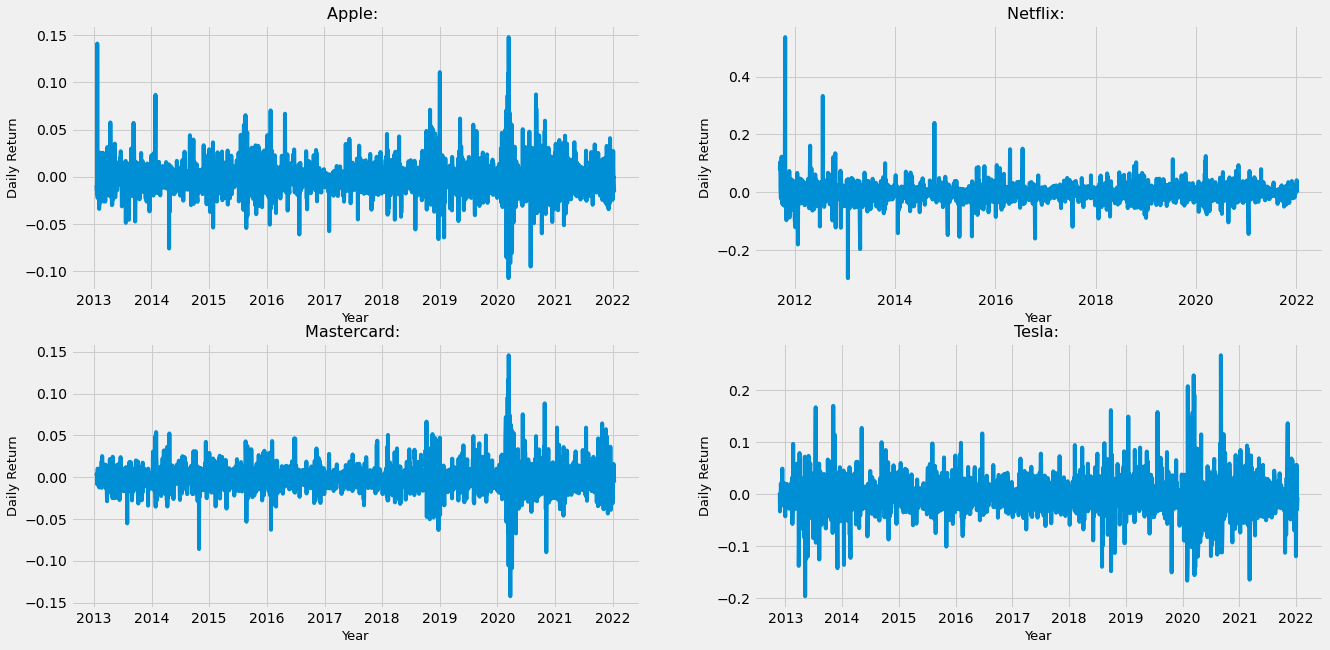

In [13]:
# Now we will create a new columns with a value that will tell us the percent change for each day accoring Adj close.

Daily_df = []
for i in range(4):
    comp = stock_data[stock_data["Company"] == stock_name[i]].copy()
    comp['Date'] = pd.to_datetime(comp['Date'])
    comp["Daily Return"] = comp['Adj Close'].pct_change()
    Daily_df.append(comp)
    plt.subplot(2, 2, i+1)
    plt.plot((Daily_df[i])['Date'], (Daily_df[i])['Daily Return'], label=stock_name[i])
    plt.title(f"{stock_name[i]}: ", fontsize = 16)
    plt.ylabel('Daily Return',fontsize = 13)
    plt.xlabel('Year',fontsize = 13)

<AxesSubplot:>

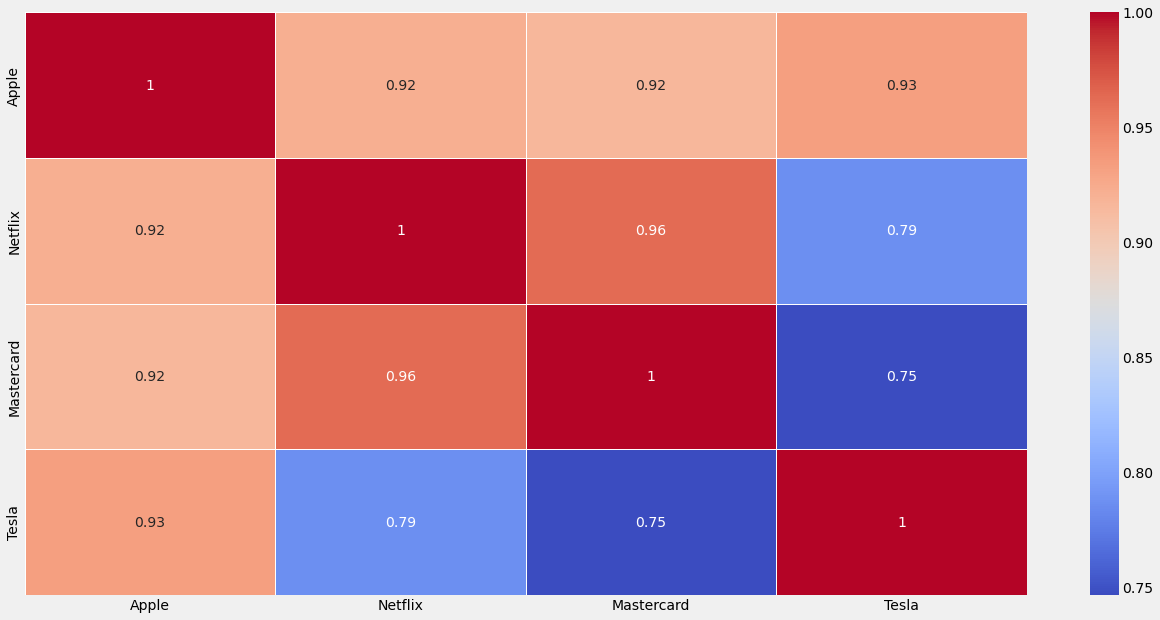

In [14]:
#Checking the Correlation between the stock on "Close" Column.
min_arr = []
cat = ['Date','Company']
for i in range(4):
    x = (stock_data.loc[stock_data['Company'] == stock_name[i]])[cat]
    min_arr.append(x.shape[0])
    
index = np.argmin(min_arr)
df_new = (stock_data.loc[stock_data['Company'] == stock_name[index]])["Date"]
df_new = df_new.to_frame()

for i in range(4):
    df_new[stock_name[i]] = (stock_data.loc[stock_data['Company'] == stock_name[i]])["Close"]

sns.heatmap(df_new.corr() , annot = True, cmap = 'coolwarm', linewidth = 0.5)

In [ ]:
# We found that there is 0.79 correlation between Tesla and Netflix
# So we decided to check the connection and  plot it on Scatterplot.
# and see what we get.

In [15]:
df_new

,Date,Apple,Netflix,Mastercard,Tesla
0,Jan 11 2022,175.08,540.84,366.29,1064.40
1,Jan 10 2022,172.19,539.85,363.91,1058.12
2,Jan 07 2022,172.17,541.06,369.65,1026.96
3,Jan 06 2022,172.00,553.29,370.00,1064.70
4,Jan 05 2022,174.92,567.52,373.90,1088.12
...,...,...,...,...,...
2257,Jan 25 2013,15.71,24.22,51.94,7.40
2258,Jan 24 2013,16.09,20.98,52.23,7.40
2259,Jan 23 2013,18.36,14.75,51.76,7.20
2260,Jan 22 2013,18.03,13.97,51.98,7.04


Text(0.5, 1.0, "Scatterplot between Netflix and Tesla 'Close': ")

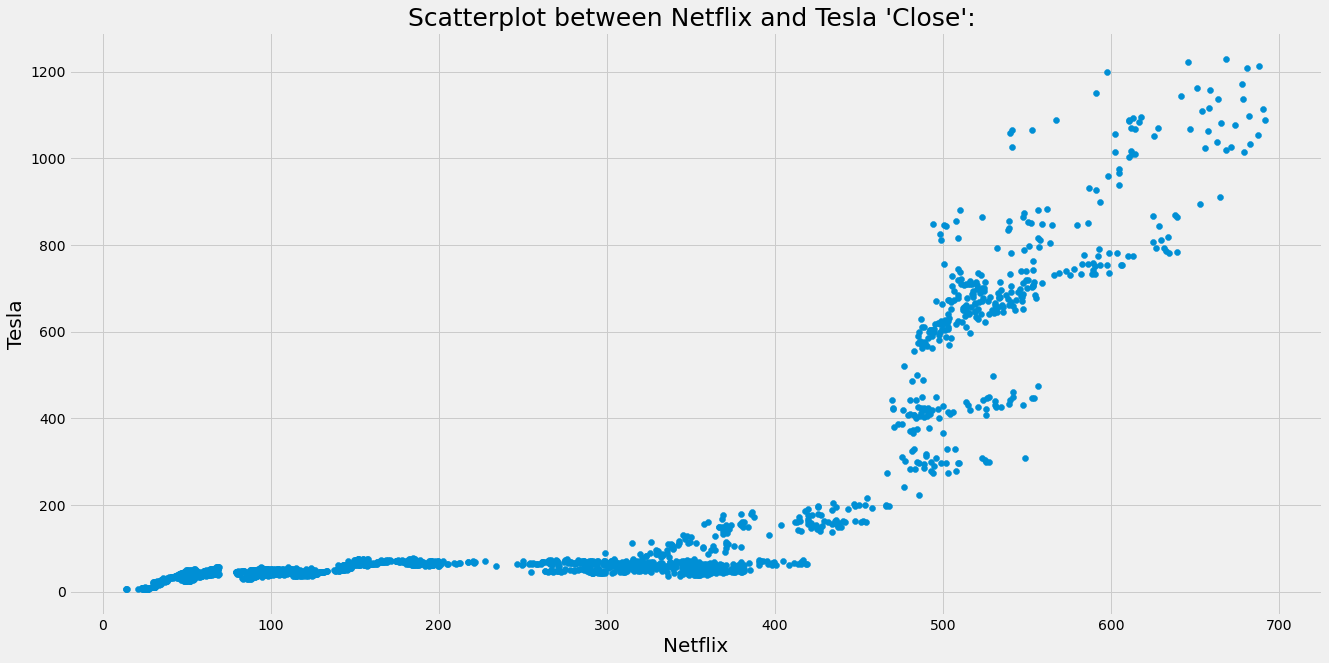

In [16]:
plt.scatter(df_new.Netflix, df_new.Tesla)
plt.ylabel('Tesla',fontsize = 20)
plt.xlabel('Netflix',fontsize = 20)
plt.title(f"Scatterplot between Netflix and Tesla 'Close': ", fontsize = 25)

Now, after we finished taking care and explore our data.

It's time to create our Model, starting with Machine Learning.

for doing that we will choose one stock from our already exsiting group.

# Machine learning:

In [17]:
print("Please Insert Yes/No to the following Question")
for i , code in enumerate(company_df,0):
    ok = input(f"Build The model on : {stock_name[i]}? ")
    if (ok == 'Yes') or (ok == 'yes'):
        data = code.copy()
        break
    else: 
        continue

Please Insert Yes/No to the following Question
Build The model on : Apple? no
Build The model on : Netflix? yes


In [18]:
data['Date'] =pd.to_datetime(data['Date'])
data.set_index(["Date"],inplace = True)
data = data.sort_values(by=['Date'])

In [19]:
data

,Open,High,Low,Close,Adj Close,Volume,Company
Date,,,,,,,
2011-09-15,25.25,26.49,24.02,24.18,24.18,148744400,Netflix
2011-09-16,23.97,24.00,22.02,22.17,22.17,124931800,Netflix
2011-09-19,22.38,23.28,20.37,20.54,20.54,139805400,Netflix
2011-09-20,20.20,20.43,18.48,18.58,18.58,224343000,Netflix
2011-09-21,18.63,19.18,17.86,18.36,18.36,158463900,Netflix
...,...,...,...,...,...,...,...
2022-01-05,592.00,592.84,566.88,567.52,567.52,4148700,Netflix
2022-01-06,554.34,563.36,542.01,553.29,553.29,5711800,Netflix
2022-01-07,549.46,553.43,538.22,541.06,541.06,3381700,Netflix


In [20]:
# Create a new dataframe with only the 'Close column 
# Convert the dataframe to a numpy array
# Get the number of rows to train the model on

data = data.filter(['Close'])
dataset = data.values
training_data_len = int(np.ceil( len(dataset) * .90 ))

training_data_len

2340

In [21]:
data

,Close
Date,
2011-09-15,24.18
2011-09-16,22.17
2011-09-19,20.54
2011-09-20,18.58
2011-09-21,18.36
...,...
2022-01-05,567.52
2022-01-06,553.29
2022-01-07,541.06


In [22]:
# Scale the data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.02410819],
       [0.02116959],
       [0.01878655],
       ...,
       [0.7797807 ],
       [0.7780117 ],
       [0.77945906]])

In [23]:
# Create the training data set 
# Create the scaled training data set
# Split the data into x_train and y_train data sets
train_data = scaled_data[0:int(training_data_len), :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
        
# Convert the x_train and y_train to numpy arrays
# Reshape the data
# x_train.shape
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

הסתכלנו במספר אתרים שהמליצו להשתמש במודל מסוג זה 

https://www.analyticsvidhya.com/blog/2021/10/machine-learning-for-stock-market-prediction-with-step-by-step-implementation/

https://neptune.ai/blog/predicting-stock-prices-using-machine-learning

In [24]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2280/2280 [==============================] - 37s 15ms/step - loss: 9.8703e-04


In [25]:
# Create the testing data set
# Create a new array containing scaled values 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)



C:\Users\User\anaconda3\envs\v-env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


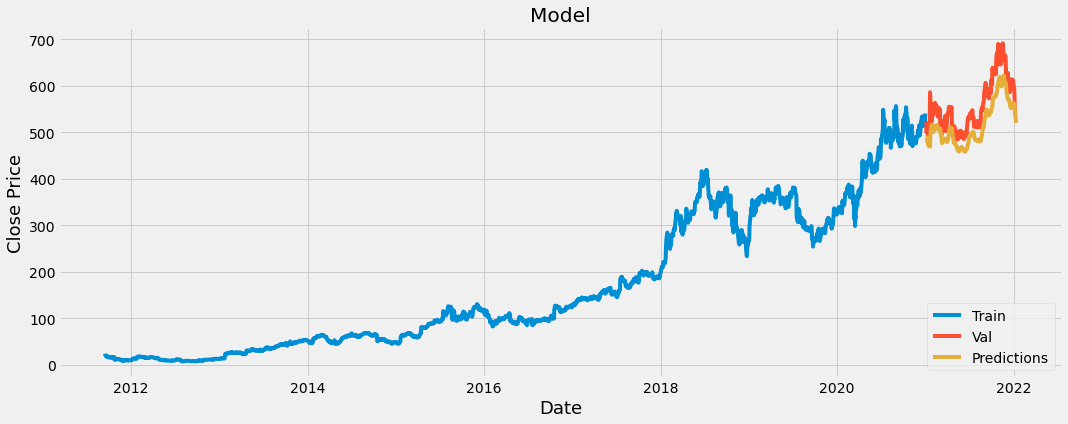

In [26]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [27]:
# Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2021-01-04,522.86,489.889587
2021-01-05,520.80,490.451233
2021-01-06,500.49,489.618347
2021-01-07,508.89,484.951141
2021-01-08,510.40,481.399200
...,...,...
2022-01-05,567.52,555.771240
2022-01-06,553.29,548.536987
2022-01-07,541.06,539.217773
